In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from tqdm import tqdm

import jobllib



ModuleNotFoundError: No module named 'jobllib'

In [2]:
# Load the original dataset
ORIGINAL_DATASET_PATH = '../data/raw/train.csv'
data = pd.read_csv(ORIGINAL_DATASET_PATH)

# Separate features and target variable
X = data.drop(columns=['loan_status'])
y = data['loan_status']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [3]:

# Split the data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing steps to the dataset
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


In [4]:
# Fit and transform the training data
X_train_processed = pipeline.fit_transform(X_train)
X_validation_processed = pipeline.transform(X_validation)


In [5]:

# Define base models for stacking
base_models = [
    ('xgboost', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('catboost', CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)


C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [6]:

# Create the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)


In [7]:

# Train the stacking model with progress bar
print("Training the stacking model...")
for _ in tqdm(range(10), desc='Training Stacking Model'):
    stacking_model.fit(X_train_processed, y_train)


Training the stacking model...


Training Stacking Model:   0%|                                                                            | 0/10 [00:00<?, ?it/s]C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Training Stacking Model:  10%|██████▊                                                             | 1/10 [00:55<08:15, 55.03s/it]C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Training Stacking Model:  20%|█████████████▌                                                      | 2/10 [01:36<06:18, 47.28s/it]C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

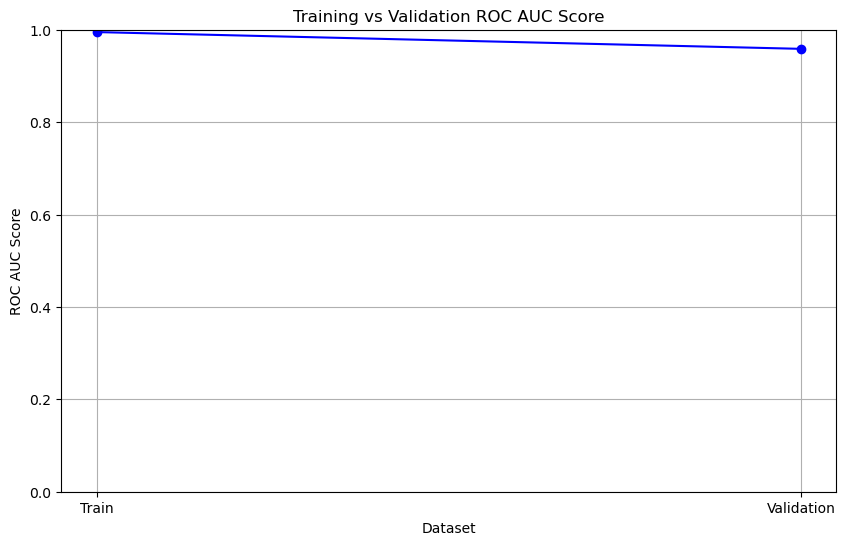

In [16]:
# Make predictions on the training set and validation set
y_train_pred_proba = stacking_model.predict_proba(X_train_processed)[:, 1]
y_validation_pred_proba = stacking_model.predict_proba(X_validation_processed)[:, 1]

# Calculate ROC AUC for training and validation sets
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
validation_roc_auc = roc_auc_score(y_validation, y_validation_pred_proba)

# Plot the ROC AUC scores to determine overfitting or underfitting
plt.figure(figsize=(10, 6))
plt.plot(['Train', 'Validation'], [train_roc_auc, validation_roc_auc], marker='o', linestyle='-', color='b')
plt.title('Training vs Validation ROC AUC Score')
plt.xlabel('Dataset')
plt.ylabel('ROC AUC Score')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

In [8]:

# Make predictions on the validation set
y_pred = stacking_model.predict(X_validation_processed)
y_pred_proba = stacking_model.predict_proba(X_validation_processed)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_validation, y_pred_proba)
print(f"Stacking Model - ROC AUC Score: {roc_auc}")
print(classification_report(y_validation, y_pred))


Stacking Model - ROC AUC Score: 0.9585952396851412
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.74      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.87      0.89     11729
weighted avg       0.95      0.95      0.95     11729



In [12]:

# Save the trained stacking model
STACKING_MODEL_PATH = '../models/stacking_model_all_features.pkl'
joblib.dump(stacking_model, STACKING_MODEL_PATH)
print(f"Stacking model saved to {STACKING_MODEL_PATH}")

Stacking model saved to ../models/stacking_model_all_features.pkl


## Submission

In [13]:
# Load the test dataset
TEST_SET_PATH = '../data/raw/test.csv'
X_test = pd.read_csv(TEST_SET_PATH)

# Apply preprocessing to the test dataset
X_test_processed = pipeline.transform(X_test)

# Make predictions on the test set
y_test_pred_proba = stacking_model.predict_proba(X_test_processed)[:, 1]

# Create a DataFrame for submission
submission = pd.DataFrame({'id': X_test['id'], 'loan_status': y_test_pred_proba})

# Save the submission to a CSV file
SUBMISSION_PATH = '../data/processed/submission.csv'
submission.to_csv(SUBMISSION_PATH, index=False)

print(f"Submission file saved to {SUBMISSION_PATH}")

Submission file saved to ../data/processed/submission.csv
